import libz

In [2]:
import torch 
import numpy as np
import pandas as pd
import numpy as np
from scipy.signal import resample
import matplotlib.pyplot as plt

In [19]:


# Load .npy file using numpy
data_array = np.load('normal_data.npy')
data_array_horizontal_misalignment_data = np.load('horizontal_misalignment_data.npy',)
data_array_imbalance_data = np.load('imbalance_data.npy')
#data_array_vertical_misalignment_data = np.load('vertical_misalignment_data.npy')

# Reshape the array to 2D
#flattened_array = data_array.reshape(-1, data_array.shape[-1])

# Convert NumPy array to pandas DataFrame
#df = pd.DataFrame(flattened_array)

# Now 'df' is a DataFrame containing the flattened data from the .npy file


size of our data

In [20]:
import sys

print(f"Memory usage of 'a': {sys.getsizeof(data_array)} bytes")
print(f"Memory usage of 'b': {sys.getsizeof(data_array_horizontal_misalignment_data)} bytes")
print(f"Memory usage of 'c': {sys.getsizeof(data_array_imbalance_data)} bytes")

Memory usage of 'a': 882000144 bytes
Memory usage of 'b': 3546000144 bytes
Memory usage of 'c': 5994000144 bytes


In [22]:
data_array.shape

(49, 9, 250000)

In [23]:
X_tensor_data = torch.tensor(data_array)

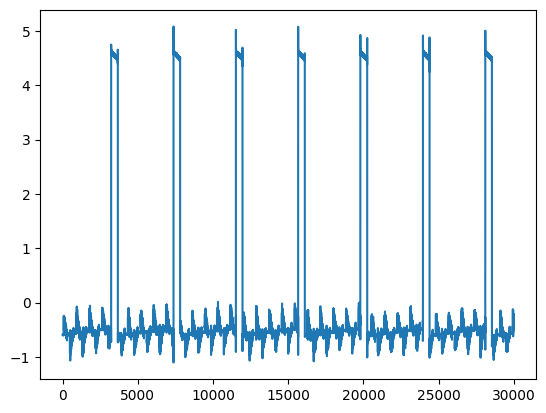

In [24]:
import matplotlib.pyplot as plt

n = int(len(data_array[0][0]))

plt.plot(np.arange(30000),data_array[0][0][n-30000:n])

In [25]:
len(X_tensor_data[0][0])

250000

#### Data Processing and Exploratory Data Analysis

Before we can feed the data into a machine learning algorithm, we need to perform some preliminary data processing. Let’s look at a plot of all the time-series signals under the normal operating condition for one training instance.

scale of our data for each sensor 

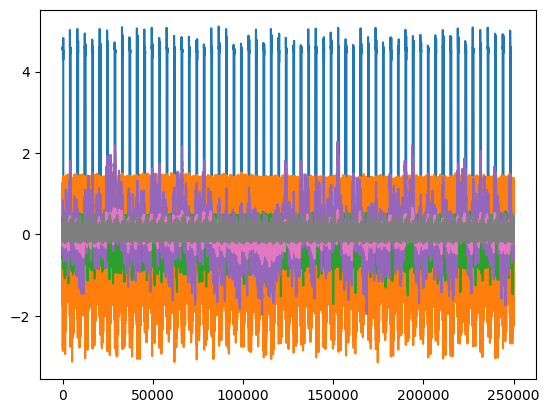

In [8]:
#instance 0 for each sensor 
fig, ax = plt.subplots()
for i in range(8):
    n = int(len(data_array[0][i]))
    ax.plot(np.arange(n),X_tensor_data[0][i])


The initial analysis of the data and data plot reveal two key insights:

    There are a large number of data points due to the high sample rate
    The signals are not on the same scale

Both of these insights would have implications on the machine learning algorithm:

    Too many data points would require longer model training times
    The different scales would skew the machine learning model results

#### Data Resampling

First, we should resample the data at a lower frequency to reduce the size of each training instance and therefore speed up the training algorithm. To determine the resampling rate, let’s analyze the frequency spectrum of signals using a Fast Fourier transform (FFT):

##### Fast Fourier Transform (FFT):

The Fast Fourier Transform (FFT) is an algorithm that efficiently computes the discrete Fourier transform (DFT) of a sequence, or its inverse. The DFT is a mathematical transformation that converts a signal from its original domain (usually time or space) to a representation in the frequency domain.

In the context of time series data, the FFT can be used to analyze the frequency components present in the signal. It decomposes a time series into its constituent frequencies, revealing the underlying periodic patterns.

Why Use FFT on Time Series Data:

    Frequency Analysis: FFT helps identify the dominant frequencies in a time series. This is crucial for understanding the periodic patterns, cycles, or trends present in the data.

    Filtering: By analyzing the frequency components, you can filter out unwanted noise or isolate specific frequency ranges that are of interest.

    Spectral Analysis: It provides a spectral representation of the time series, enabling the identification of significant frequency components and their amplitudes.

    Feature Extraction: FFT can be used to extract features from the time domain to be used in machine learning models.

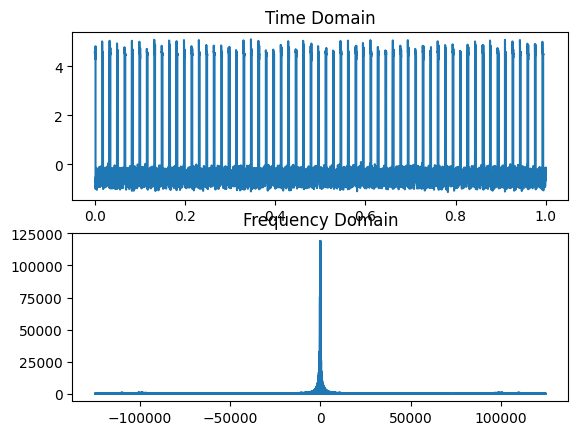

In [9]:
signal =X_tensor_data[0][0]
n = int(len(X_tensor_data[0][0]))
t = np.linspace(0, 1, n, endpoint=False)  
# Compute FFT
fft_result = np.fft.fft(signal)
freq = np.fft.fftfreq(n, d=t[1]-t[0])

# Plot the time series and its frequency spectrum
plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title('Time Domain')

plt.subplot(2, 1, 2)
plt.plot(freq, np.abs(fft_result))
plt.title('Frequency Domain')

plt.show()

In [10]:
int(len(data_array[0][0]))

250000

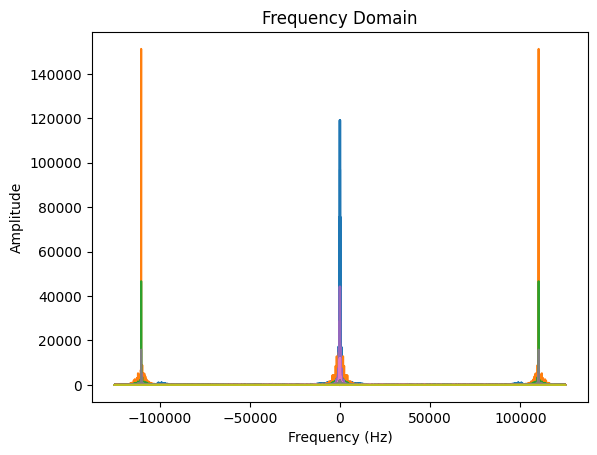

In [11]:

fig, ax = plt.subplots()
n = int(len(data_array[0][0]))
t = np.linspace(0, 1, n, endpoint=False) 

for i in range(9):
    signal =X_tensor_data[0][i]
    
    # Compute FFT
    fft_result = np.fft.fft(signal)
    freq = np.fft.fftfreq(n, d=t[1]-t[0])

    ax.plot(freq, np.abs(fft_result))
    plt.title('Frequency Domain')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')

    #ax.plot(freq, np.abs(fft_result))



    Yes, it is normal to have negative values in the "Frequency (Hz)" when performing the Fast Fourier Transform (FFT) of a signal. In the context of the FFT, the frequency axis is typically represented as a two-sided spectrum, where positive frequencies are shown on one side and negative frequencies on the other. This is a result of the complex nature of the FFT output, which includes both positive and negative frequency components.

    The presence of negative frequencies in the FFT output is a mathematical consequence of the way the FFT is computed. In many practical applications, the negative frequency components are often discarded or not displayed, as they are redundant due to the symmetry of the FFT output for real-valued input signals. However, in some cases, such as when analyzing complex-valued signals or when working with two-sided spectra, the negative frequency components are relevant and should be considered.

    In summary, the presence of negative values in the "Frequency (Hz)" when performing the FFT is a normal and expected behavior, and it is a result of the complex nature of the FFT output and the two-sided nature of the frequency spectrum. The interpretation of the negative frequency components depends on the specific application and the nature of the input signal.

    Citations:
    [1] https://en.wikipedia.org/wiki/Negative_frequency
    [2] https://youtube.com/watch?v=gz6AKW-R69s
    [3] https://mriquestions.com/negative-frequencies.html
    [4] https://www.khanacademy.org/science/electrical-engineering/ee-circuit-analysis-topic/ee-ac-analysis/v/ee-negative-frequency
    [5] https://youtube.com/watch?v=DYailAUjt2E

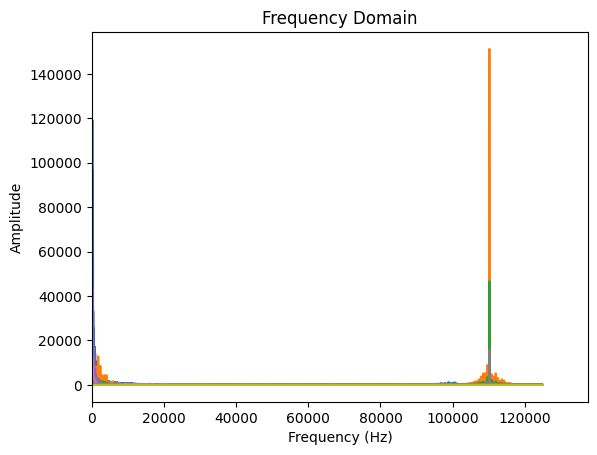

In [12]:
plt.figure(fig) 
plt.xlim(0, None)
plt.show()

The FFT shows a large percentage of high signal strength frequencies located at a lower frequency bandwidth (0 Hz — 5,000 Hz). There is a second bandwidth of relatively high strength frequencies at 100,000 Hz — 120,000 Hz, and there is a dead-band between 20,000 Hz and 90,000 Hz. At the cost of losing information from the high-frequency bandwidth, a decision is made to resample the data at a lower rate of 500 Hz. The lower sampling rate would reduce the number of time-series data points from 250,000 to 2,500, which is two orders of magnitude lower; therefore, significantly reducing the model training time.

In [36]:


# Assuming you have a signal and its original sampling rate
original_signal = X_tensor_data[0][0]  # Replace with your actual data
original_sampling_rate = len(X_tensor_data[0][0])  # Replace with your actual sampling rate

# Calculate the resampling factor
resampling_factor = original_sampling_rate / 500

# Resample the signal to the target sampling rate of 500 Hz
resampled_signal = resample(original_signal, int(len(original_signal) / resampling_factor))

# Create a time axis for both original and resampled signals
original_time = np.linspace(0, len(original_signal) / original_sampling_rate, len(original_signal))
resampled_time = np.linspace(0, len(resampled_signal) / 500, len(resampled_signal))




In [35]:
# Plot the original and resampled signals
def visualize_og_re_signal(original_time,original_signal,resampled_signal):
    plt.figure(figsize=(10, 5))

    plt.subplot(2, 1, 1)
    plt.plot(original_time, original_signal, label='Original Signal')
    plt.title('Original Signals')
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)
    plt.plot(resampled_time, resampled_signal, label='Resampled Signal (500 Hz)')
    plt.title('Resampled Signals')
    plt.ylabel('Amplitude')

    plt.xlabel('Time (seconds)')


    plt.legend()
    plt.show()


    plt.show()

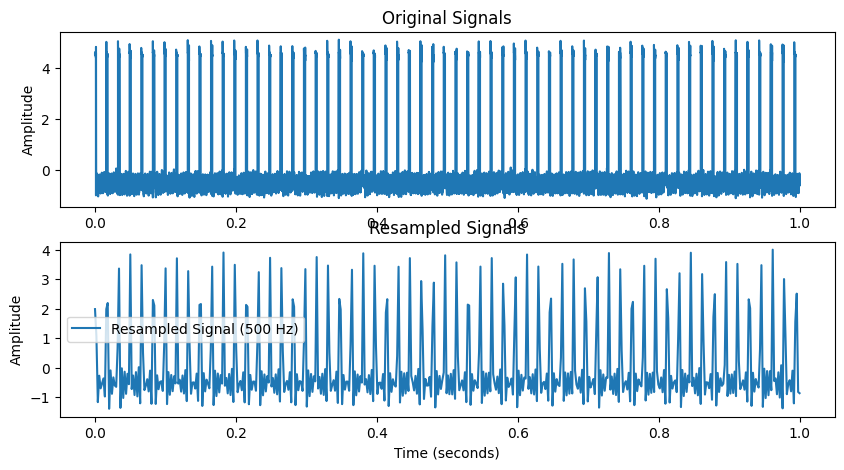

In [37]:
visualize_og_re_signal(original_time,original_signal,resampled_signal)

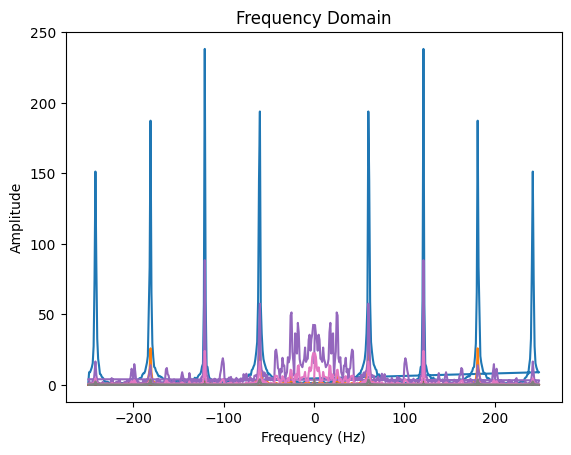

In [15]:
original_sampling_rate = len(X_tensor_data[0][0]) 
# Calculate the resampling factor
resampling_factor = original_sampling_rate / 500

fig, ax = plt.subplots()

for i in range(8) :
    # Assuming you have a signal and its original sampling rate
    original_signal = X_tensor_data[0][i]  # Replace with your actual data

    # Resample the signal to the target sampling rate of 500 Hz
    resampled_signal = resample(original_signal, int(len(original_signal) / resampling_factor))

    resampled_time = np.linspace(0, len(resampled_signal))


    signal =resampled_signal

    n = int(len(resampled_signal))
    
    t = np.linspace(0, 1, n, endpoint=False)  
    # Compute FFT
    fft_result = np.fft.fft(signal)
    freq = np.fft.fftfreq(n, d=t[1]-t[0])

    ax.plot(freq, np.abs(fft_result))
    plt.title('Frequency Domain')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')


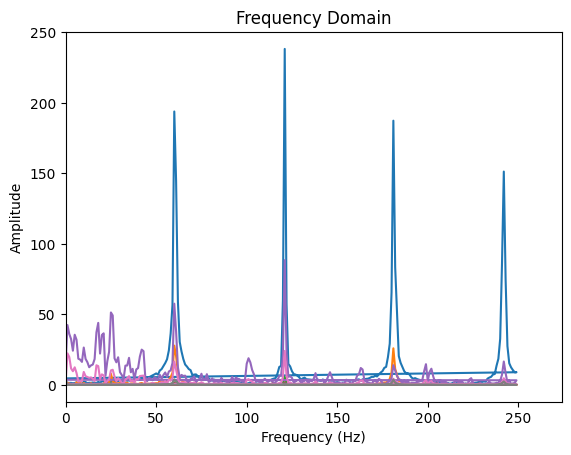

In [16]:
plt.figure(fig) 
plt.xlim(0, None)
plt.show()

lets now resample the data for the normal case at a rate of 500 hz 

In [32]:
def resample_data(X_tensor_data):
    new_tensor_data = torch.empty_like(X_tensor_data[:, :, :500])
    for instance in range(len(X_tensor_data)):
        for sensor in range(8) :
            # Assuming you have a signal and its original sampling rate
            original_signal = X_tensor_data[instance][sensor]  # Replace with your actual data
            original_sampling_rate = len(X_tensor_data[instance][sensor])  

            # Calculate the resampling factor
            resampling_factor = original_sampling_rate / 500

            # Resample the signal to the target sampling rate of 500 Hz
            resampled_signal = resample(original_signal, int(len(original_signal) / resampling_factor))

            # Update the original signal with the resampled signal
            new_tensor_data[instance][sensor] = torch.from_numpy(resampled_signal)

    return new_tensor_data




In [33]:
X_tensor_data.shape

torch.Size([49, 9, 250000])

In [34]:
normal_X_tensor_data = resample_data(X_tensor_data)
normal_X_tensor_data.shape

torch.Size([49, 9, 500])

In [38]:
# Assuming you have a signal and its original sampling rate
original_signal = X_tensor_data[0][0]  # Replace with your actual data
original_sampling_rate = len(X_tensor_data[0][0])  # Replace with your actual sampling rate

# Calculate the resampling factor
resampling_factor = original_sampling_rate / 500

# Resample the signal to the target sampling rate of 500 Hz
resampled_signal = resample(original_signal, int(len(original_signal) / resampling_factor))

# Create a time axis for both original and resampled signals
original_time = np.linspace(0, len(original_signal) / original_sampling_rate, len(original_signal))
resampled_time = np.linspace(0, len(resampled_signal) / 500, len(resampled_signal))

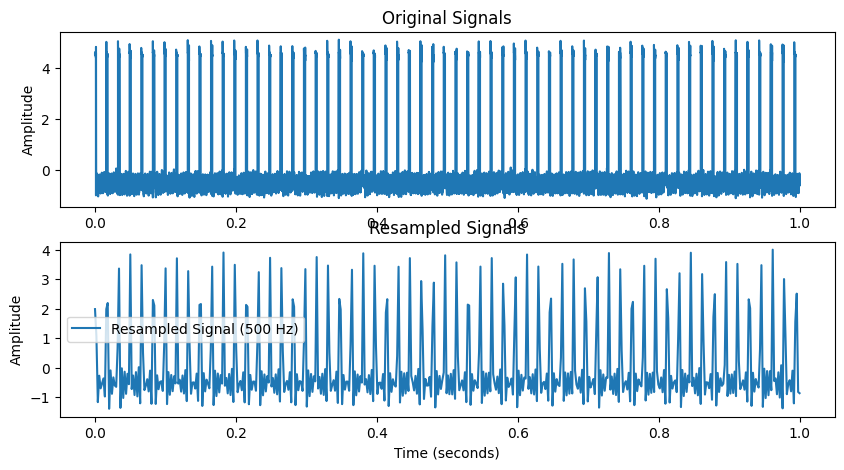

In [40]:
visualize_og_re_signal(original_time,original_signal,normal_X_tensor_data[0][0])

size of data in normal case 

In [44]:
import sys

print(f"Memory usage of 'a': {sys.getsizeof(data_array)} bytes")
print(f"Memory usage of 'b': {sys.getsizeof(normal_X_tensor_data.numpy())} bytes")


Memory usage of 'a': 882000144 bytes
Memory usage of 'b': 144 bytes


### Data Scaling

The next data processing step is to rescale the signals to a common scale. This function would ensure that the machine learning model does not skew the final results.

before scaling

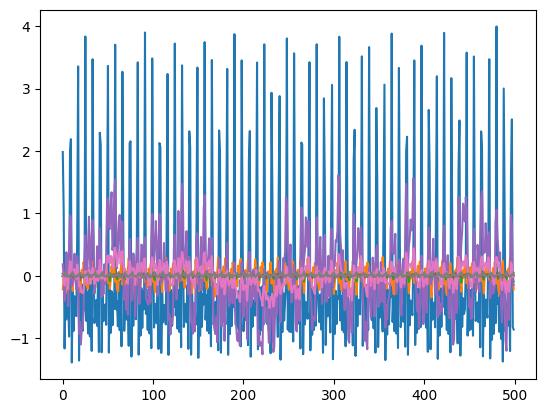

In [45]:
#instance 0 for each sensor 
fig, ax = plt.subplots()
for i in range(8):
    n = int(len(normal_X_tensor_data[0][i]))
    ax.plot(np.arange(n),normal_X_tensor_data[0][i])

In [57]:
normal_X_tensor_data[0][:8].shape #exclude normal_X_tensor_data[0][:8] bc it s the class == normal

torch.Size([8, 500])

In [65]:
len(normal_X_tensor_data)

49

Min max scaling

In [82]:
def scale(normal_X_tensor_data):
    new_tensor_data = torch.empty_like(normal_X_tensor_data[:, :, :500])

    for instance in range(len(normal_X_tensor_data)):

        time_series_data = normal_X_tensor_data[instance][:8] 
        # Min-Max Scaling using NumPy
        min_val = torch.min(time_series_data, axis=1, keepdims=True).values
        max_val = torch.max(time_series_data, axis=1, keepdims=True).values
        scaled_data = (time_series_data - min_val) / (max_val - min_val)

        new_tensor_data[instance][:8] = scaled_data
        new_tensor_data[instance][8] = normal_X_tensor_data[instance][8] 
    return new_tensor_data


our New data for normal case

In [84]:
scaled_normal_X_tensor_data = scale(normal_X_tensor_data)

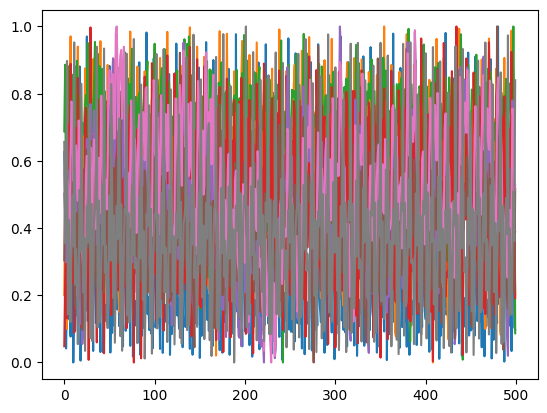

In [85]:
fig, ax = plt.subplots()
for i in range(8):
    n = int(len(scaled_normal_X_tensor_data[0][i]))
    ax.plot(np.arange(n),scaled_normal_X_tensor_data[0][i])

### Frequency Domain

The final step in the data processing pipeline is to convert the signals from time domain to frequency domain. This conversion is achieved by transforming the data using a FFT. The benefits of transforming the data to the frequency domain are:

    By using only the positive spectrum of frequencies, the number of rows per training set decreased from 2,500 to 1,250; therefore, reducing the model training time
    The frequency spectrum has more indicative characteristics per operating condition; therefore, improving the model accuracy

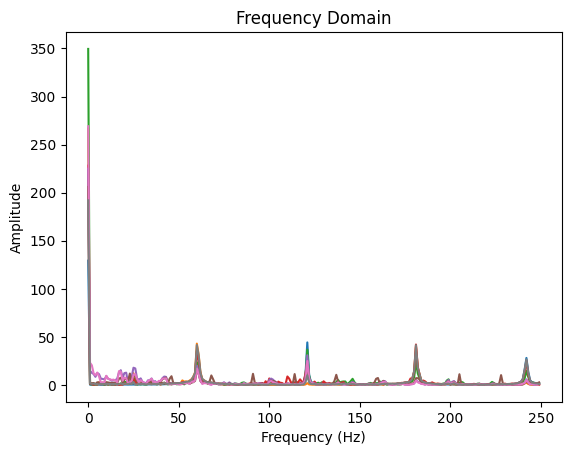

In [113]:
fig, ax = plt.subplots()

n = int(len(scaled_normal_X_tensor_data[0][0]))
t = np.linspace(0, 1, n, endpoint=False) 

for sensor in range(8):
    # Assuming 'signal' is your time series data
    signal = scaled_normal_X_tensor_data[0][sensor]

    # Compute FFT
    fft_result = np.fft.fft(signal)
    freq = np.fft.fftfreq(len(signal), d=t[1]-t[0])

    # Get only the positive frequencies
    positive_freq_mask = freq >= 0
    positive_freq = freq[positive_freq_mask]
    positive_fft_result = fft_result[positive_freq_mask]

    # Now, 'positive_freq' and 'positive_fft_result' contain only the positive frequencies and corresponding FFT values.

    ax.plot(positive_freq, np.abs(positive_fft_result))
    plt.title('Frequency Domain')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')

        #ax.plot(freq, np.abs(fft_result))



In [114]:

def fft_transform(scaled_normal_X_tensor_data):
        new_tensor_data = torch.empty_like(normal_X_tensor_data[:, :, :250])
        for instance in range(len(scaled_normal_X_tensor_data)):
                for sensor in range(8):
                        # Assuming 'signal' is your time series data
                        signal = scaled_normal_X_tensor_data[instance][sensor]

                        # Compute FFT
                        fft_result = np.fft.fft(signal)
                        freq = np.fft.fftfreq(len(signal), d=t[1]-t[0])

                        # Get only the positive frequencies
                        positive_freq_mask = freq >= 0
                        positive_fft_result = fft_result[positive_freq_mask]

                        new_tensor_data[instance][sensor] =torch.from_numpy(positive_fft_result)
                        new_tensor_data[instance][8] = normal_X_tensor_data[instance][8][:250] 
        return new_tensor_data
                

we finaly have our scaled data in the frequency domain , this is the data that we will be using for training our model .

In [116]:
scaled_normal_X_tensor_data_freq_domain = fft_transform(scaled_normal_X_tensor_data)

In [127]:
scaled_normal_X_tensor_data_freq_domain.numpy()

(49, 9, 250)

In [128]:
# Convert PyTorch tensor to NumPy array
# Save NumPy array as .npy file
np.save('normal_data_scaled_freq_domain.npy', scaled_normal_X_tensor_data_freq_domain)

### FAULTS DATA

let s create a pipleine to do the same thing to the faulty data

#### Pipline 

IMBALANCE DATA

In [27]:
def resample_data(X_tensor_imbalance_data):
    new_tensor_data = torch.empty_like(X_tensor_imbalance_data[:, :, :500])
    for instance in range(len(X_tensor_imbalance_data)):
        for sensor in range(8) :
            # Assuming you have a signal and its original sampling rate
            original_signal = X_tensor_imbalance_data[instance][sensor]  # Replace with your actual data
            original_sampling_rate = len(X_tensor_imbalance_data[instance][sensor])  

            # Calculate the resampling factor
            resampling_factor = original_sampling_rate / 500

            # Resample the signal to the target sampling rate of 500 Hz
            resampled_signal = resample(original_signal, int(len(original_signal) / resampling_factor))

            # Update the original signal with the resampled signal
            new_tensor_data[instance][sensor] = torch.from_numpy(resampled_signal)

    return new_tensor_data


def scale(X_tensor_imbalance_data):
    new_tensor_data = torch.empty_like(X_tensor_imbalance_data[:, :, :500])

    for instance in range(len(X_tensor_imbalance_data)):

        time_series_data = X_tensor_imbalance_data[instance][:8] 
        # Min-Max Scaling using NumPy
        min_val = torch.min(time_series_data, axis=1, keepdims=True).values
        max_val = torch.max(time_series_data, axis=1, keepdims=True).values
        scaled_data = (time_series_data - min_val) / (max_val - min_val)

        new_tensor_data[instance][:8] = scaled_data
        new_tensor_data[instance][8] = X_tensor_imbalance_data[instance][8] 
    return new_tensor_data



#frequency domain
def fft_transform(X_tensor_imbalance_data):
        n = int(len(X_tensor_imbalance_data[0][0]))
        t = np.linspace(0, 1, n, endpoint=False) 
        new_tensor_data = torch.empty_like(X_tensor_imbalance_data[:, :, :250])
        for instance in range(len(X_tensor_imbalance_data)):
                for sensor in range(8):
                        # Assuming 'signal' is your time series data
                        signal = X_tensor_imbalance_data[instance][sensor]

                        # Compute FFT
                        fft_result = np.fft.fft(signal)
                        freq = np.fft.fftfreq(len(signal), d=t[1]-t[0])

                        # Get only the positive frequencies
                        positive_freq_mask = freq >= 0
                        positive_fft_result = fft_result[positive_freq_mask]

                        new_tensor_data[instance][sensor] =torch.from_numpy(positive_fft_result)
                        new_tensor_data[instance][8] = X_tensor_imbalance_data[instance][8][:250] 
        return new_tensor_data

In [24]:
""" 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer """

# Assuming resample_data, scale, and fft_transform are your custom functions
# Import and define your functions here

# Create the pipeline
""" pipeline = Pipeline([
    ('resample', FunctionTransformer(resample_data)),
    ('scale', FunctionTransformer(scale)),
    ('fft', FunctionTransformer(fft_transform))
]) """

# Fit the pipeline to your data



let s try it on the imbalance_data

In [ ]:
data_array_imbalance_data = np.load('imbalance_data.npy')
X_tensor_imbalance_data = torch.tensor(data_array_imbalance_data)

In [12]:
X_tensor_imbalance_data = torch.tensor(data_array_imbalance_data)

In [19]:
X_tensor_imbalance_data.shape

torch.Size([333, 9, 250000])

In [28]:
rslt = resample_data(X_tensor_imbalance_data)
rslt = scale(rslt)
rslt = fft_transform(rslt)

C:\Users\heeln\AppData\Local\Temp\ipykernel_24032\2525400275.py:56: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ..\aten\src\ATen\native\Copy.cpp:299.)
  new_tensor_data[instance][sensor] =torch.from_numpy(positive_fft_result)


In [29]:
rslt.shape

torch.Size([333, 9, 250])

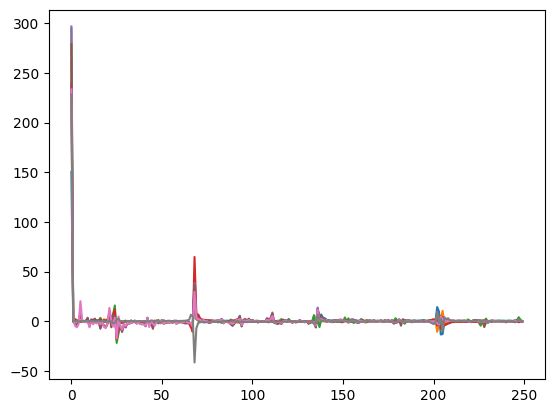

In [34]:
fig, ax = plt.subplots()
for i in range(8):
    n = int(len(rslt[0][i]))
    ax.plot(np.arange(n),rslt[0][i])

In [35]:
np.save('imbalance_data_scaled_freq_domain.npy', rslt)

horizontal_misalignment_data

In [39]:
data_array_horizontal_misalignment_data = np.load('horizontal_misalignment_data.npy')
X_tensor_horizontal_misalignment_data = torch.tensor(data_array_horizontal_misalignment_data)

In [40]:
rslt = resample_data(X_tensor_horizontal_misalignment_data)
rslt = scale(rslt)
rslt = fft_transform(rslt)

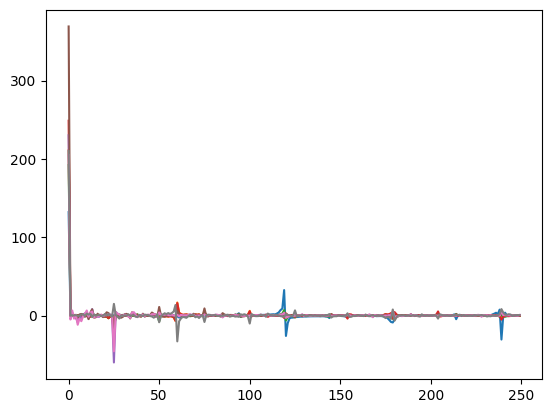

In [41]:
fig, ax = plt.subplots()
for i in range(8):
    n = int(len(rslt[0][i]))
    ax.plot(np.arange(n),rslt[0][i])

In [42]:
np.save('horizontal_misalignment_data_data_scaled_freq_domain.npy', rslt)

In [37]:
del X_tensor_imbalance_data

In [38]:
del data_array_imbalance_data

vertical_misalignment_data

In [47]:
del rslt
del X_tensor_horizontal_misalignment_data
del data_array_horizontal_misalignment_data

NameError: name 'rslt' is not defined

In [44]:
data_array_vertical_misalignment = np.load('vertical_misalignment_data.npy')

RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 5418000000 bytes.

In [49]:
X_tensor_vertical_misalignment  = torch.tensor(data_array_vertical_misalignment)

RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 5418000000 bytes.

In [ ]:
rslt = resample_data(X_tensor_vertical_misalignment)
rslt = scale(rslt)
rslt = fft_transform(rslt)

In [2]:
X_tensor_data_imbalance_data = torch.tensor(data_array_imbalance_data)
original_sampling_rate = len(X_tensor_data_imbalance_data[0][0]) 

In [5]:
X_tensor_data_imbalance_data.shape

torch.Size([333, 9, 250000])

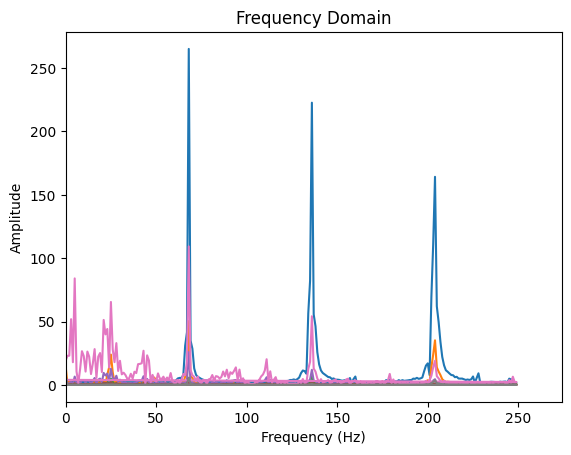

In [8]:
# Calculate the resampling factor
resampling_factor = original_sampling_rate / 500

fig, ax = plt.subplots()

for i in range(8) :
    # Assuming you have a signal and its original sampling rate
    original_signal = X_tensor_data_imbalance_data[0][i]  # Replace with your actual data

    # Resample the signal to the target sampling rate of 500 Hz
    resampled_signal = resample(original_signal, int(len(original_signal) / resampling_factor))

    resampled_time = np.linspace(0, len(resampled_signal))


    signal =resampled_signal

    n = int(len(resampled_signal))
    
    t = np.linspace(0, 1, n, endpoint=False)  
    # Compute FFT
    fft_result = np.fft.fft(signal)
    freq = np.fft.fftfreq(n, d=t[1]-t[0])

    ax.plot(freq, np.abs(fft_result))
    plt.title('Frequency Domain')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')

plt.figure(fig) 
plt.xlim(0, None)
plt.show()


In [ ]:
X_tensor_data_horizontal_misalignment_data = torch.tensor(data_array_horizontal_misalignment_data)
original_sampling_rate = len(X_tensor_data_horizontal_misalignment_data[0][0]) 

# Calculate the resampling factor
resampling_factor = original_sampling_rate / 500

fig, ax = plt.subplots()

for i in range(8) :
    # Assuming you have a signal and its original sampling rate
    original_signal = X_tensor_data_horizontal_misalignment_data[0][i] 

    # Resample the signal to the target sampling rate of 500 Hz
    resampled_signal = resample(original_signal, int(len(original_signal) / resampling_factor))

    resampled_time = np.linspace(0, len(resampled_signal))


    signal =resampled_signal

    n = int(len(resampled_signal))
    
    t = np.linspace(0, 1, n, endpoint=False)  
    # Compute FFT
    fft_result = np.fft.fft(signal)
    freq = np.fft.fftfreq(n, d=t[1]-t[0])

    ax.plot(freq, np.abs(fft_result))
    plt.title('Frequency Domain')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')

plt.figure(fig) 
plt.xlim(0, None)
plt.show()


create a pipeline function that will be used to preprocess the data 

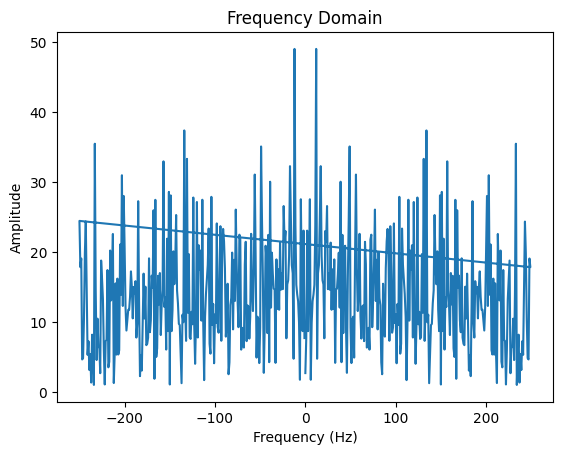

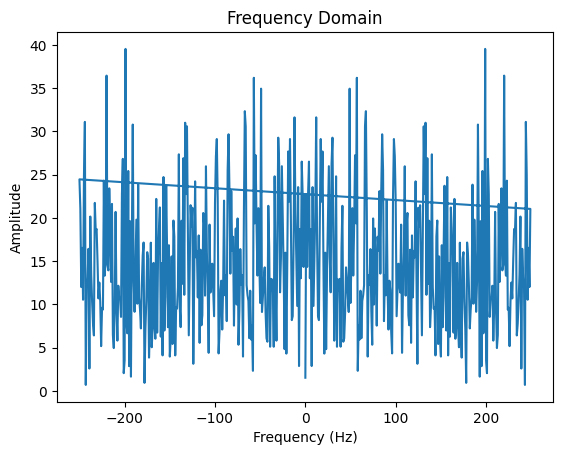

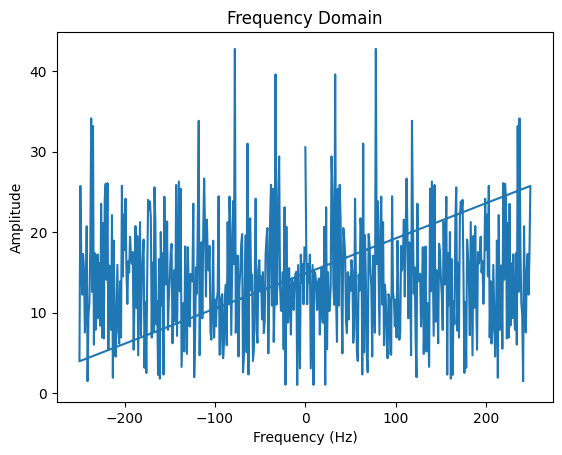

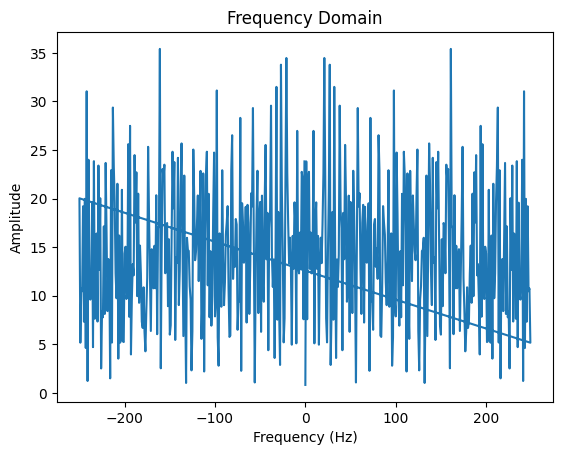

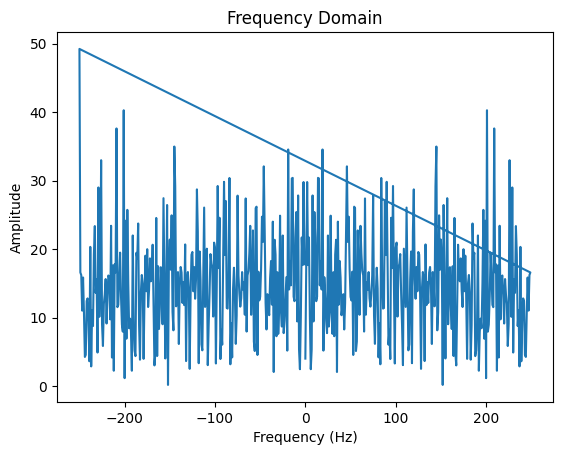

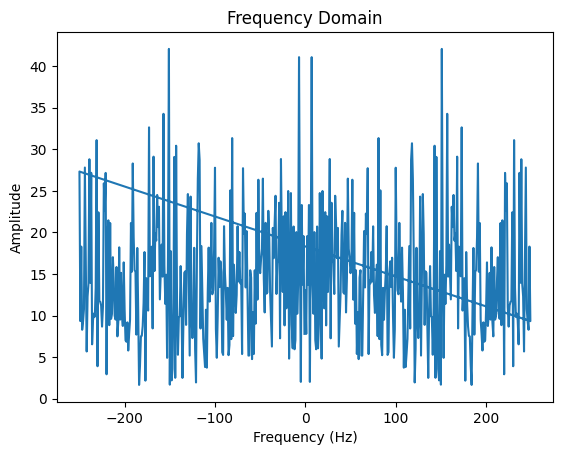

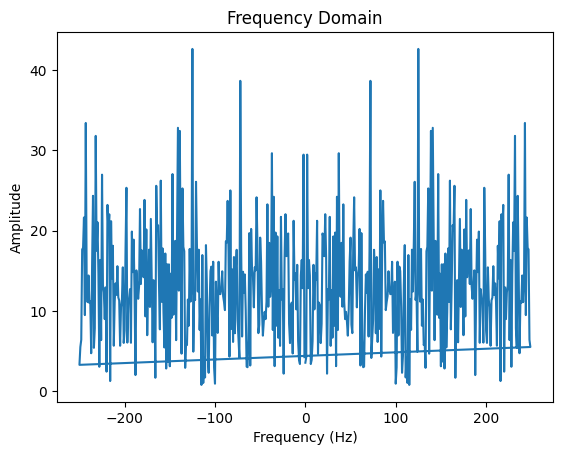

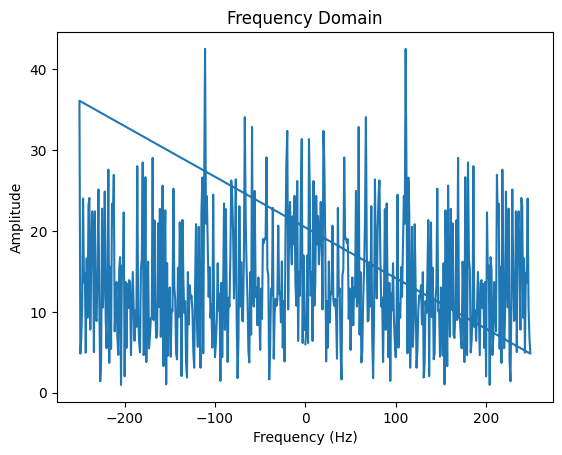

In [2]:

def process_signal(original_signal, target_sampling_rate=500):
    # Resample the signal to the target sampling rate
    resampling_factor = len(original_signal) / target_sampling_rate
    resampled_signal = resample(original_signal, int(len(original_signal) / resampling_factor))

    # Compute FFT
    n = len(resampled_signal)
    t = np.linspace(0, 1, n, endpoint=False)  
    fft_result = np.fft.fft(resampled_signal)
    freq = np.fft.fftfreq(n, d=t[1]-t[0])

    return freq, np.abs(fft_result)

def plot_frequency_domain(freq, amplitude, title='Frequency Domain', xlabel='Frequency (Hz)', ylabel='Amplitude'):
    fig, ax = plt.subplots()
    ax.plot(freq, amplitude)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

def process_and_plot_dataset(dataset):
    for i in range(dataset.shape[1]):  # Assuming dataset is a 2D array
        original_signal = dataset[0][i]
        freq, amplitude = process_signal(original_signal)
        plot_frequency_domain(freq, amplitude)

# Example Usage:
data_array_horizontal_misalignment_data = np.random.randn(1, 8, 1000)  # Example dataset
X_tensor_data_horizontal_misalignment_data = torch.tensor(data_array_horizontal_misalignment_data)

process_and_plot_dataset(X_tensor_data_horizontal_misalignment_data)
